# Import Libraries

In [248]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [249]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

In [250]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [251]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
data_info = pd.read_excel("./data/data_info.xlsx")

## 결측치 처리

<AxesSubplot:>

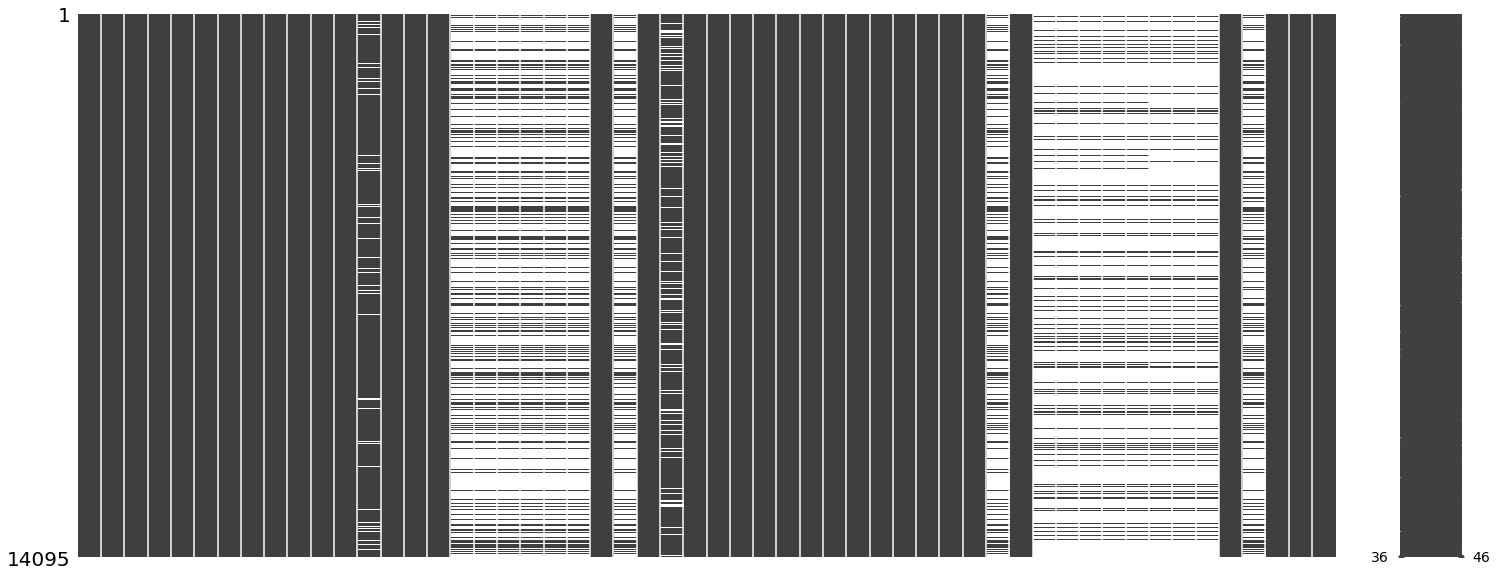

In [252]:
import missingno as msno
msno.matrix(train)

In [253]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [254]:
drop_columns = data_info[data_info["드랍칼럼"]=="○"]["Feature Name"]
drop_columns = drop_columns.tolist()
drop_columns

['ID',
 'SAMPLE_TRANSFER_DAY',
 'FH2O',
 'FNOX',
 'FOXID',
 'FSO4',
 'FTBN',
 'LI',
 'P',
 'PB',
 'S',
 'SB',
 'SN',
 'SOOTPERCENTAGE',
 'U20',
 'U14',
 'U6',
 'U4',
 'V100']

In [255]:
train = train.drop(columns = drop_columns, axis = 1)
train.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,AL,B,BA,BE,CA,...,SI,TI,U100,U75,U50,U25,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,2011,200,0,3,93,0,0,3059,...,427,5,NaN,NaN,NaN,NaN,0,154.0,75,0
1,COMPONENT2,1350,2021,375,0,2,19,0,0,2978,...,0,0,0.0,0.0,1.0,2.0,0,44.0,652,0


In [256]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  object 
 1   ANONYMOUS_1          14095 non-null  int64  
 2   YEAR                 14095 non-null  int64  
 3   ANONYMOUS_2          14095 non-null  int64  
 4   AG                   14095 non-null  int64  
 5   AL                   14095 non-null  int64  
 6   B                    14095 non-null  int64  
 7   BA                   14095 non-null  int64  
 8   BE                   14095 non-null  int64  
 9   CA                   14095 non-null  int64  
 10  CD                   12701 non-null  float64
 11  CO                   14095 non-null  int64  
 12  CR                   14095 non-null  int64  
 13  CU                   14095 non-null  int64  
 14  FOPTIMETHGLY         3890 non-null   float64
 15  FE                   14095 non-null 

<AxesSubplot:>

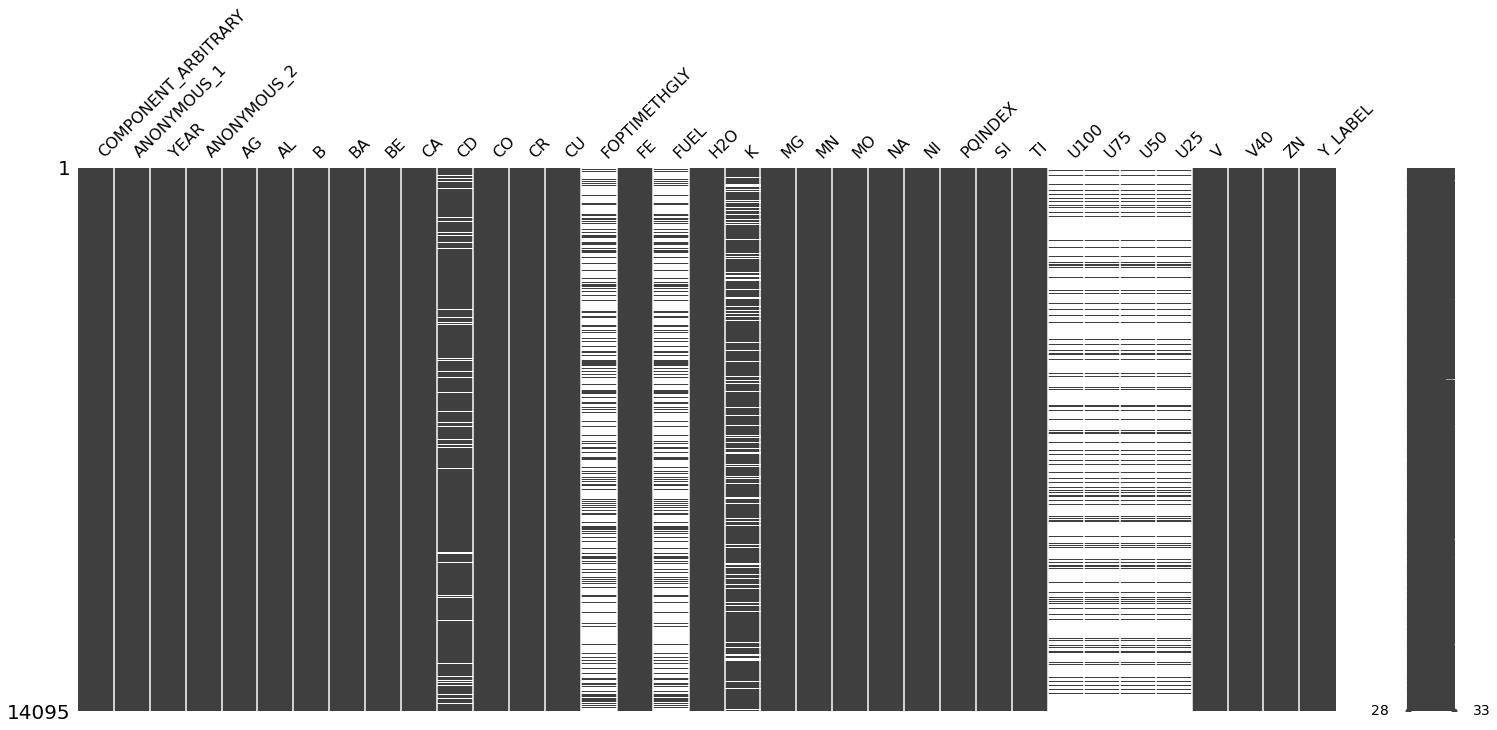

In [257]:
msno.matrix(train)

In [258]:
train["CD"].isna().any()

True

In [259]:
train["CD"].mean(), train["CD"].median()

(0.015589323675301157, 0.0)

In [260]:
for col in train.columns.tolist():
    print(col)
    if train[col].isna().any():
        train[col] = train[col].fillna(train[col].median())
    else:
        pass        

COMPONENT_ARBITRARY
ANONYMOUS_1
YEAR
ANONYMOUS_2
AG
AL
B
BA
BE
CA
CD
CO
CR
CU
FOPTIMETHGLY
FE
FUEL
H2O
K
MG
MN
MO
NA
NI
PQINDEX
SI
TI
U100
U75
U50
U25
V
V40
ZN
Y_LABEL


<AxesSubplot:>

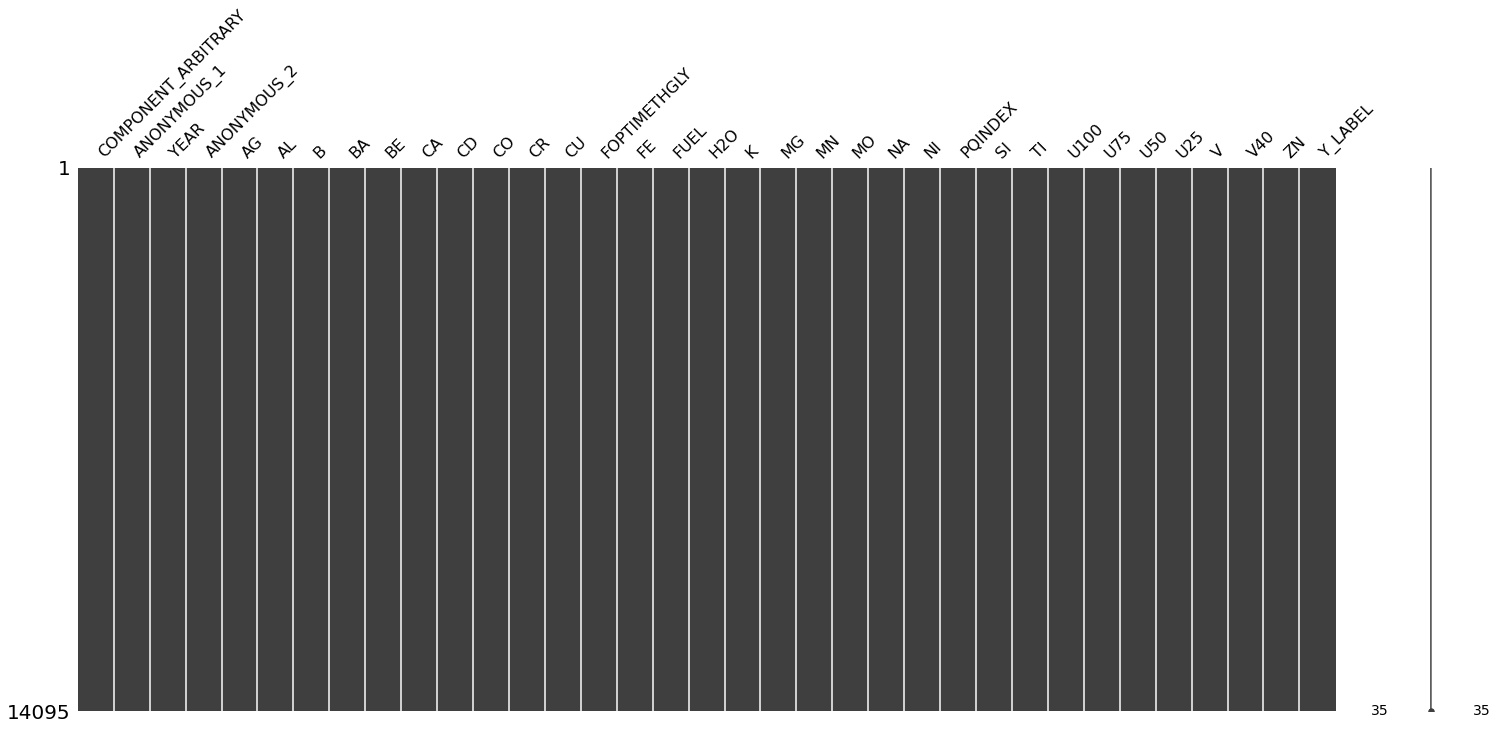

In [261]:
msno.matrix(train)

In [262]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [263]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [264]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

In [265]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [266]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [267]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [268]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=34, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [269]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [270]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [271]:
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.25329] Val Loss : [0.27397] Val F1 Score : [0.77213]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.19026] Val Loss : [0.22345] Val F1 Score : [0.77905]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.17653] Val Loss : [0.23020] Val F1 Score : [0.79161]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.16635] Val Loss : [0.28009] Val F1 Score : [0.78962]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.15994] Val Loss : [0.26912] Val F1 Score : [0.79526]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.16572] Val Loss : [0.28800] Val F1 Score : [0.77698]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.18003] Val Loss : [0.30264] Val F1 Score : [0.80236]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.15712] Val Loss : [0.23942] Val F1 Score : [0.79041]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15638] Val Loss : [0.33574] Val F1 Score : [0.79477]
Epoch 00009: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.14758] Val Loss : [0.27663] Val F1 Score : [0.79901]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.13953] Val Loss : [0.31252] Val F1 Score : [0.79136]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.15166] Val Loss : [0.25974] Val F1 Score : [0.79911]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.14333] Val Loss : [0.29562] Val F1 Score : [0.79976]
Epoch 00013: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.13149] Val Loss : [0.30067] Val F1 Score : [0.80194]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.13252] Val Loss : [0.26966] Val F1 Score : [0.80801]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.12799] Val Loss : [0.26382] Val F1 Score : [0.79849]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.12718] Val Loss : [0.27542] Val F1 Score : [0.79672]
Epoch 00017: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.13039] Val Loss : [0.29156] Val F1 Score : [0.79672]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.12643] Val Loss : [0.28842] Val F1 Score : [0.79752]
Epoch 00019: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.12236] Val Loss : [0.27914] Val F1 Score : [0.79927]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.12352] Val Loss : [0.30166] Val F1 Score : [0.79193]
Epoch 00021: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.13140] Val Loss : [0.30347] Val F1 Score : [0.79274]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.13309] Val Loss : [0.28697] Val F1 Score : [0.79666]
Epoch 00023: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.12100] Val Loss : [0.29116] Val F1 Score : [0.77657]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.11980] Val Loss : [0.29535] Val F1 Score : [0.80356]
Epoch 00025: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.12128] Val Loss : [0.30714] Val F1 Score : [0.79515]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.11997] Val Loss : [0.28943] Val F1 Score : [0.79293]
Epoch 00027: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.11897] Val Loss : [0.30989] Val F1 Score : [0.80099]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.13108] Val Loss : [0.28383] Val F1 Score : [0.78711]
Epoch 00029: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.12129] Val Loss : [0.28947] Val F1 Score : [0.78959]


In [272]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [273]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [274]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [275]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model

In [276]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [277]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [278]:
student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.34478] Val Loss : [0.31621] Val F1 Score : [0.49738]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.31510] Val Loss : [0.31206] Val F1 Score : [0.51575]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.31202] Val Loss : [0.31552] Val F1 Score : [0.48543]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.31049] Val Loss : [0.30704] Val F1 Score : [0.50812]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.30484] Val Loss : [0.30888] Val F1 Score : [0.49765]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.30330] Val Loss : [0.30748] Val F1 Score : [0.50685]
Epoch 00006: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.30011] Val Loss : [0.30788] Val F1 Score : [0.51287]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.30362] Val Loss : [0.30703] Val F1 Score : [0.52471]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.30311] Val Loss : [0.30978] Val F1 Score : [0.52144]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.29808] Val Loss : [0.30852] Val F1 Score : [0.51107]
Epoch 00010: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.29812] Val Loss : [0.30752] Val F1 Score : [0.51415]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.29638] Val Loss : [0.30773] Val F1 Score : [0.52094]
Epoch 00012: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.29870] Val Loss : [0.30794] Val F1 Score : [0.52421]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.29433] Val Loss : [0.30633] Val F1 Score : [0.52418]
Epoch 00014: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.29410] Val Loss : [0.30885] Val F1 Score : [0.52445]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.29893] Val Loss : [0.30919] Val F1 Score : [0.52366]
Epoch 00016: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.29716] Val Loss : [0.30812] Val F1 Score : [0.52606]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.29442] Val Loss : [0.30661] Val F1 Score : [0.52110]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.29158] Val Loss : [0.31052] Val F1 Score : [0.52395]
Epoch 00019: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.29774] Val Loss : [0.30786] Val F1 Score : [0.52288]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.29222] Val Loss : [0.30747] Val F1 Score : [0.52262]
Epoch 00021: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.29803] Val Loss : [0.30747] Val F1 Score : [0.52043]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.29403] Val Loss : [0.30722] Val F1 Score : [0.52186]
Epoch 00023: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.29153] Val Loss : [0.30781] Val F1 Score : [0.51647]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.29277] Val Loss : [0.30734] Val F1 Score : [0.51647]
Epoch 00025: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.29305] Val Loss : [0.30687] Val F1 Score : [0.52949]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.29713] Val Loss : [0.30816] Val F1 Score : [0.52018]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.29509] Val Loss : [0.30933] Val F1 Score : [0.52018]
Epoch 00028: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.29212] Val Loss : [0.30664] Val F1 Score : [0.52018]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.29307] Val Loss : [0.30782] Val F1 Score : [0.52068]
Epoch 00030: reducing learning rate of group 0 to 2.4414e-06.


In [279]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [280]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/12 [00:00<?, ?it/s]

Best Threshold : [0.2], Score : [0.55468]


In [281]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [282]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [283]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


In [284]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,1


In [285]:
submit.to_csv('./submit1.csv', index=False)